# Racial bias analysis in police stops.

We want to study the data used by stanford in their paper to check if the characteristics of a police officer are linked to a potential racial bias in stops.

To this end, we will use the stops data of the state police of Florida, and analyse behaviors towards white, black, or hispanic people.

# Summary:
- [Data exploration](#Exploration)
- [Statewide bias score](#Statewide_score)
- [County adjusted bias score](#County_score)

## First, let's gather and clean the data:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import copy

from tqdm import tqdm

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [5]:
folder = 'data/'
state = folder + 'fl_statewide.csv.zip'

keep_columns = ['date', 'time', 'county_name', 'subject_age', 'subject_race', 'subject_sex', 'officer_id_hash', 'officer_age', 'officer_race', 'officer_sex', 'officer_years_of_service', 'arrest_made', 'citation_issued', 'warning_issued', 'frisk_performed', 'search_conducted']
mandatory_columns = ['date', 'time', 'subject_age', 'subject_race', 'subject_sex', 'officer_id_hash', 'officer_age', 'officer_race', 'officer_sex', 'officer_years_of_service', 'arrest_made', 'citation_issued', 'warning_issued', 'search_conducted']
minorities = ['white', 'hispanic', 'black']
boolean_columns = ['arrest_made', 'citation_issued', 'warning_issued', 'frisk_performed', 'search_conducted']

### Helper functions

In [3]:
def type_booleans(df):
    """ type a column in boolean if possible to reduce size and handability of dataframe
    """
    global boolean_columns
    for col in boolean_columns:
        if df_full[col].isna().sum() == 0:
            df_full[col] = df_full[col].astype(bool)
        else:
            print(f"Cannot convert {col} columns to boolean")

def print_info_df(df):
    """ print summary of dataframe and values in columns if not too long
    """
    print("Dataset is composed of {} stops. Columns are: \n".format(df.shape[0]))
    for col in df.columns:
        if df.dtypes[col] != np.float64:
            val = df[col].unique()
            if len(val) > 20:
                print('{} \t\t: too much different values'.format(col))
            else:
                print('{} \t\t: values are: {}'.format(col if len(col)>15 else col + "\t\t", val))

def generate_smaller_data(df, keep_ratio, path):
    """ Write new csv of reduced size in path and returns it
    """
    total_size = df.shape[0]
    df_red = df.sample(n=int(total_size * keep_ratio))
    df_red.to_csv(path, index = False)
    return df_red

## Loading and cleaning florida dataset

In [6]:
# load all dataset
df_full = pd.read_csv(state)
print(len(df_full))

C:\Users\lenovo\Anaconda3\envs\ada\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3,7,10,11,13,14,17,18,19,21,22,23,24,26,27,28,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


7297538


In [7]:
df_full.drop(columns=df_full.columns.difference(keep_columns), inplace=True) # drop unused columns
df_full.dropna(subset=mandatory_columns, how='any', inplace=True) # drop nan values in mandatory columns
df_full['date'] = pd.to_datetime(df_full['date']) # to datetime
df_full['year'] = df_full['date'].dt.to_period('y')
df_full = df_full.rename(columns={'officer_years_of_service': 'officer_yos'})

print(len(df_full))
df_full.head()

2879765


,date,time,county_name,subject_age,subject_race,subject_sex,officer_id_hash,officer_age,officer_race,officer_sex,officer_yos,arrest_made,citation_issued,warning_issued,frisk_performed,search_conducted,year
1,2010-01-06,16:14:43,Duval County,23.0,white,female,a23eeba673,31.0,black,male,8.0,False,False,False,False,False,2010
2,2010-01-08,19:39:31,Duval County,45.0,white,female,f0489ce476,29.0,white,male,3.0,True,False,False,False,False,2010
3,2010-01-11,11:56:34,St. Lucie County,41.0,white,male,bb47e316ba,26.0,white,male,3.0,False,True,False,False,False,2010
6,2010-01-15,09:18:02,Gadsden County,26.0,white,male,6cdcbc9d4b,47.0,white,male,0.0,False,False,True,False,False,2010
7,2010-01-15,10:16:59,Gadsden County,42.0,hispanic,male,6cdcbc9d4b,47.0,white,male,0.0,False,False,False,False,True,2010


<a id = Exploration></a>
## Data exploration

In [8]:
# grasp on the data : is there spelling mistakes for gender, race; nan values; ...
print_info_df(df_full)

Dataset is composed of 2879765 stops. Columns are: 

date 		: too much different values
time 		: too much different values
county_name 		: too much different values
subject_race		 		: values are: ['white' 'hispanic' 'black' 'asian/pacific islander' 'other']
subject_sex		 		: values are: ['female' 'male']
officer_id_hash 		: too much different values
officer_race		 		: values are: ['black' 'white' 'hispanic' 'unknown' 'asian/pacific islander' 'other']
officer_sex		 		: values are: ['male' 'female']
arrest_made		 		: values are: [False True]
citation_issued		 		: values are: [False True]
warning_issued		 		: values are: [False True]
frisk_performed		 		: values are: [False True]
search_conducted 		: values are: [False True]
year		 		: values are: <PeriodArray>
['2010', '2011', '2012', '2013', '2014', '2015']
Length: 6, dtype: period[A-DEC]


In [9]:
# keep same minorities as papers 
# df_full = df_full[df_full['subject_race'].isin(minorities)]
df_full = df_full[df_full['officer_race'].isin(minorities)]
type_booleans(df_full)

<a id = Statewide_score></a>
# Bias score
## Goal
The goal here is to determined *how* the characteristics of an officer influence its bias towards minorities 

## How
- An officer : arrest over a N-year period
- Raw bias score for officer o towards minority m $ B(o,m) = \frac{N_{stops~of~m}}{N_{total~stops~over~the~period}} $
- Strong assumption: $median(\{B(o,m) / o \in S\})$ is actually the proportion of the population of $S$ which is from minority $m$ 
- Bias score for minority $m$ for an officer in a set of officers of region $S$ : $ B_m = \frac{N_{stops~of~m}}{N_{total~stops~over~the~period}} - median(\{B(o,m) / o \in S\})$

The study is held this way : 
- $S$ is statewide : see the coefficient statewide

## Definition of first officer dataframe

In [10]:
df_officers = df_full.groupby(['year', 'officer_id_hash', 'officer_race', 'officer_sex'])['officer_yos', 'officer_age']
df_officers = df_officers.min().reset_index()
df_officers.set_index(['year', 'officer_id_hash'], inplace=True, verify_integrity=True)
df_officers.head()

C:\Users\lenovo\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


officer_race officer_sex  officer_yos  officer_age
year officer_id_hash                                                   
2010 000f298db7          hispanic        male         10.0         33.0
     0045d4113d             black        male          0.0         30.0
     008bb7857a             white        male         22.0         46.0
     01088eec71             white        male          0.0         31.0
     0142b8fe8c             white        male         14.0         44.0

In [11]:
# build dataframe linking (year, officer) to their number of arrest of minorities
df_yearly = df_full.groupby(['year', 'officer_id_hash', 'subject_race'])['date'].count().to_frame().reset_index()
df_yearly.rename(columns={'date':'stops'}, inplace=True)
df_yearly = df_yearly.pivot_table(columns='subject_race', values='stops', index=['year', 'officer_id_hash'], fill_value=0)
df_yearly['total'] = df_yearly.sum(axis=1)
df_yearly.head()

subject_race          asian/pacific islander  black  hispanic  other  white  \
year officer_id_hash                                                          
2010 000f298db7                           10     58       112      9    287   
     0045d4113d                            4     67       222     12     76   
     008bb7857a                            2     13        49      3     60   
     01088eec71                           16     87        25     14    908   
     0142b8fe8c                            2     48        33      7    186   

subject_race          total  
year officer_id_hash         
2010 000f298db7         476  
     0045d4113d         381  
     008bb7857a         127  
     01088eec71        1050  
     0142b8fe8c         276

In [12]:
# drop officers with too few arrest
stop_threshold = 300
df_yearly = df_yearly[df_yearly['total'] > stop_threshold]
print(f'There are {len(df_yearly)} entries left')

There are 3612 entries left


In [13]:
# add raw bias
for m in minorities:
        df_yearly[f'raw_bias_{m}'] = df_yearly[m] / df_yearly['total']

# compute medians
raw_bias_medians = { m : df_yearly[f'raw_bias_{m}'].median() for m in minorities}

# add bias
for m in minorities:
    df_yearly[f'bias_{m}'] = df_yearly[f'raw_bias_{m}'] - raw_bias_medians[m]

df_yearly.head()

subject_race          asian/pacific islander  black  hispanic  other  white  \
year officer_id_hash                                                          
2010 000f298db7                           10     58       112      9    287   
     0045d4113d                            4     67       222     12     76   
     01088eec71                           16     87        25     14    908   
     01f6eed4ab                            8    277       240     21    451   
     0206a7e7cf                            4     96        21      2    264   

subject_race          total  raw_bias_white  raw_bias_hispanic  \
year officer_id_hash                                             
2010 000f298db7         476        0.602941           0.235294   
     0045d4113d         381        0.199475           0.582677   
     01088eec71        1050        0.864762           0.023810   
     01f6eed4ab         997        0.452357           0.240722   
     0206a7e7cf         387        0.682171           0.054264   

subject_race          raw_bias_black  bias_white  bias_hispanic  bias_black  
year officer_id_hash                                                         
2010 000f298db7             0.121849    0.012927       0.068961   -0.052006  
     0045d4113d             0.175853   -0.390539       0.416344    0.001998  
     01088eec71             0.082857    0.274748      -0.142523   -0.090998  
     01f6eed4ab             0.277834   -0.137657       0.074389    0.103979  
     0206a7e7cf             0.248062    0.092157      -0.112069    0.074207

In [14]:
bias_df = df_yearly.merge(df_officers, how='left', left_index=True, right_index=True, validate='one_to_one')
bias_df.head(1)

,,asian/pacific islander,black,hispanic,other,white,total,raw_bias_white,raw_bias_hispanic,raw_bias_black,bias_white,bias_hispanic,bias_black,officer_race,officer_sex,officer_yos,officer_age
year,officer_id_hash,,,,,,,,,,,,,,,,
2010,000f298db7,10,58,112,9,287,476,0.602941,0.235294,0.121849,0.012927,0.068961,-0.052006,hispanic,male,10.0,33.0


## Let's fit a linear regression to study a potential link between the officer features and the score.

In [26]:
# fit models
for m in minorities:
    print()
    print(f'--------------{m.upper()}--------------')
    res = smf.ols(formula=f'bias_{m} ~ C(officer_race) + C(officer_sex) + officer_age', data=bias_df).fit()
    print(res.summary())


--------------WHITE--------------
                            OLS Regression Results                            
Dep. Variable:             bias_white   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     251.4
Date:                Fri, 18 Dec 2020   Prob (F-statistic):          9.53e-191
Time:                        23:35:37   Log-Likelihood:                 1411.2
No. Observations:                3612   AIC:                            -2812.
Df Residuals:                    3607   BIC:                            -2781.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

### Analysis
- The results are the opposite of what was expected : the bias score toward a minority m increases when the officer is of the same race
- The age seems to diminish the bias score of the officer

**Conclusion**
- The assumption "median of raw biases toward m = proportion of m in the local population" does not work.

<AxesSubplot:xlabel='county_name', ylabel='Count'>

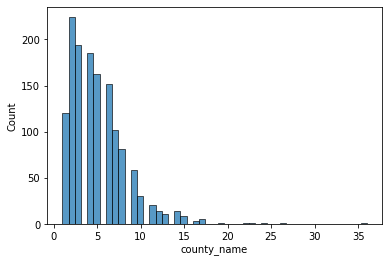

In [27]:
# number of counties in which an officer appears
county_per_officer = df_full.groupby('officer_id_hash')['county_name'].nunique()
sns.histplot(county_per_officer)

### Observations
All officers have more than 1 county.

<a id = County_score></a>
# County adjusted bias score.

## Goal

We previously attempted to define a statewide bias score to study the influence of officer's characteristics. <br/>
It is possible that differences in the the racial repartition of local population influence this score. In order to get rid of this effect, we tried to normalise the scores by county.

However, we noticed that officers often operate on multiple counties. Hence, it was not possible to just assign an officer to a county to adjust the scores. This is why the score will now be adjusted according to the county where *each stop* occures. 

In summary, each officer will have a "county score", and his bias score will be the mean of these scores, weighted by the proportion of stops he made in each counties.

The county score is the relative variation from the mean in the county.

For the county $c$ and minority $m$, we denote $x_{c, m} = \frac{\text{Number of stops of}~m~\text{in}~c}{\text{Total number of stops over the period in}~c}$

For officer $o$, we denote $p_{c, m, o} = \frac{\text{Number of stops of}~m~\text{in}~c~\text{by}~o}{\text{Total number of stops over the period in}~c~\text{by}~o}$


Finally, $N_o$ is the total number of stops by officer $o$, and $N_{o, c}$ is the number of stops by $o$ in county $c$.

We can now define an adjusted bias score for officer $o$ towards minority $m$ :

$$\boxed{\text{Score}_{o, m} = \frac{1}{N_o}\sum_c\left( N_{o,c} \cdot \frac{p_{c, m, o} - x_{c, m}}{x_{c, m}} \right)}$$

*N.B.* : minority denotes here only an ethnie, no matter the percentage of the population it represents.

### New helpers

In [28]:
def create_year_hash(df):
    df['officer_hash_year'] = df['officer_id_hash'] + '-' + df['year'].astype(str)

#Used to compute the score of an officer
def score_by_county(officer_df, minority, county_means, relative = True):
    county_stop_proportion_minority = officer_df.groupby('county_name')[minority + '_stoped'].mean()
    county_stop_count = officer_df.groupby('county_name')[minority + '_stoped'].count()
    county_stop_prop = county_stop_count/county_stop_count.sum()
    if (relative is True):
        return (((county_stop_proportion_minority - county_means[minority].loc[county_stop_proportion_minority.index])/county_means[minority].loc[county_stop_proportion_minority.index])*county_stop_prop).sum()
    else:
        return ((county_stop_proportion_minority - county_means[minority].loc[county_stop_proportion_minority.index])*county_stop_prop).sum()
    
def age_map(x):
    if (x < 32):
        return "young"
    elif(x > 50):
        return "old"
    else:
        return "middle"

#### Creation of a hash by officer and year:

In [29]:
df = df_full.copy()
create_year_hash(df)

In [30]:
stops_required = 300

print("{:.0f}% of officers have enough stops.".format((df.groupby('officer_hash_year')['date'].count() > stops_required).mean()*100))

56% of officers have enough stops.


In [31]:
officers_to_keep = df.groupby('officer_hash_year')['year'].count().loc[df.groupby('officer_hash_year')['year'].count() > stops_required].index

df = df[df.officer_hash_year.isin(officers_to_keep)]

print(len(df))

2456046


In [32]:
for minority in minorities:
    df[minority + '_stoped'] = (df['subject_race'] == minority)

#Computation the % of stops for each minority in each county
county_means = {}
for minority in minorities:
    county_means[minority] = df.groupby('county_name')[minority + '_stoped'].mean()

#### Computation of the bias scores

In [33]:
scores = {}
for minority in tqdm(minorities):
    scores[minority] = df.groupby('officer_hash_year').apply(score_by_county, minority, county_means)

100%|██████████| 3/3 [00:34<00:00, 11.34s/it]


#### Let's link these scores to the officers.

In [35]:
officer_numerics = ['officer_age', 'officer_yos']
officer_cat = ['officer_race', 'officer_sex']

# Create a dataframe with the characteristics of officers.
officer_df = df.groupby('officer_hash_year')[officer_numerics].mean()

officer_df[officer_cat] = (df[['officer_hash_year'] + officer_cat].drop_duplicates()).set_index('officer_hash_year')

# Add the bias score
for minority in minorities:
    officer_df[minority + '_bias'] = scores[minority]

## Once again, let's perform regressions to study the link between officer characteristics and scores.

In [37]:
for minority in minorities:
    print()
    print(f'--------------{minority.upper()}--------------')
    res = smf.ols(formula=f'{minority}_bias ~ C(officer_race) + C(officer_sex) + officer_age + officer_yos', data=officer_df).fit()
    print(res.summary())
    print()
    print()


--------------WHITE--------------
                            OLS Regression Results                            
Dep. Variable:             white_bias   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     11.55
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           4.31e-11
Time:                        23:36:54   Log-Likelihood:                 1244.8
No. Observations:                3612   AIC:                            -2478.
Df Residuals:                    3606   BIC:                            -2440.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

### There does not seem to be a statistically significant link between the parameters considered and the score defined. Let's look directly at the distribution of scores according to the parameters.

In [38]:
biases = ['white_bias', 'hispanic_bias', 'black_bias']

minorities = ['white', 'hispanic', 'black']
sexes = ['male', 'female']
ages = ['young', 'middle', 'old']

choice_params = {'minority':minorities, 'sex':sexes, 'age': ages}
choice_category = {'minority':'officer_race', 'sex': 'officer_sex', 'age': 'officer_generation'}


In [39]:
generation = officer_df['officer_age'].apply(age_map)

officer_df['officer_generation'] = generation

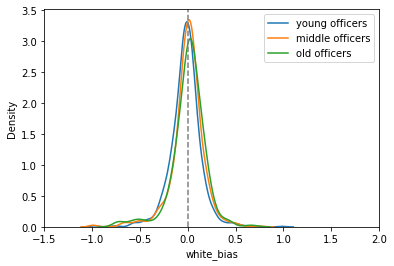

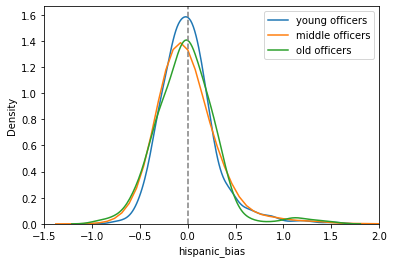

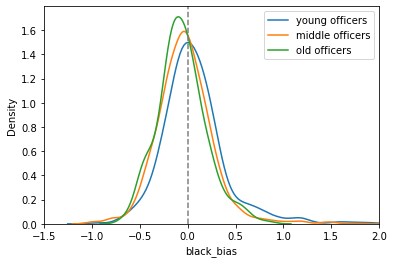

In [40]:
choice = 'age' #Possibilities : 'age', 'sex', 'minority'

for bias in biases:
    axs =  plt.axes()
    for m in choice_params[choice]:
        sns.kdeplot(officer_df[officer_df[choice_category[choice]] == m][bias], label = m + " officers", ax = axs)
    axs.axvline(x=0, ymin=0, ymax=100, linestyle='dashed', color = 'grey')
    axs.set_xlim([-1.5,2])
    plt.legend()
    plt.show()

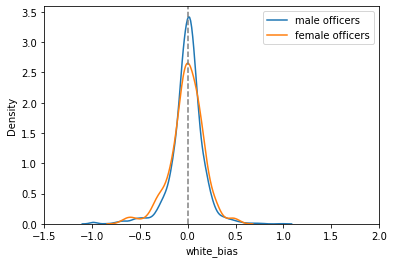

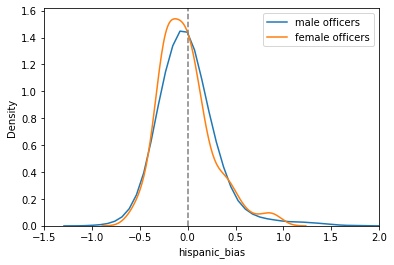

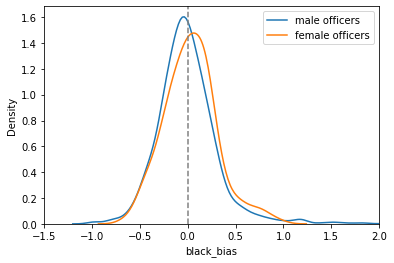

In [41]:
choice = 'sex' #Possibilities : 'age', 'sex', 'minority'

for bias in biases:
    axs =  plt.axes()
    for m in choice_params[choice]:
        sns.kdeplot(officer_df[officer_df[choice_category[choice]] == m][bias], label = m + " officers", ax = axs)
    axs.axvline(x=0, ymin=0, ymax=100, linestyle='dashed', color = 'grey')
    axs.set_xlim([-1.5,2])
    plt.legend()
    plt.show()

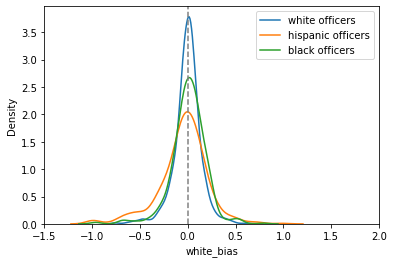

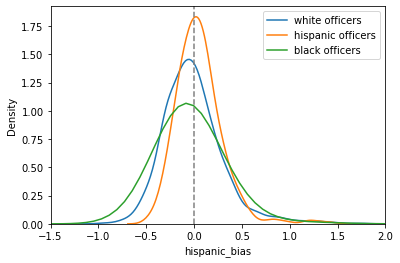

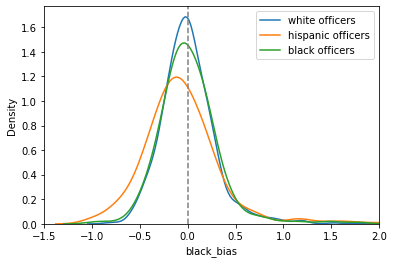

In [42]:
choice = 'minority' #Possibilities : 'age', 'sex', 'minority'

for bias in biases:
    axs =  plt.axes()
    for m in choice_params[choice]:
        sns.kdeplot(officer_df[officer_df[choice_category[choice]] == m][bias], label = m + " officers", ax = axs)
    axs.axvline(x=0, ymin=0, ymax=100, linestyle='dashed', color = 'grey')
    axs.set_xlim([-1.5,2])
    plt.legend()
    plt.show()

In [43]:
mapping = {'hispanic': 'y', 
          'black': 'k', 
          'white':'r'}
colors = [mapping[r] for r in officer_df['officer_race']]

<IPython.core.display.Javascript object>


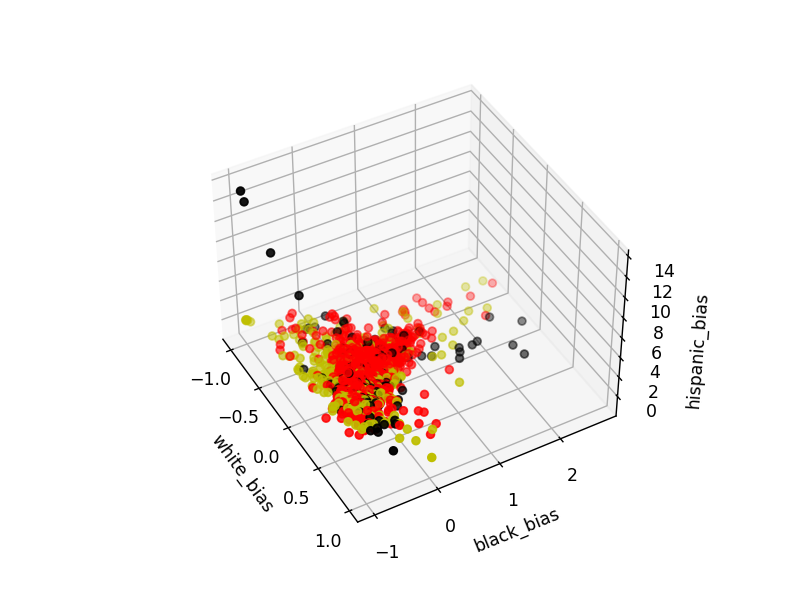

In [44]:
from mpl_toolkits.mplot3d import axes3d

%matplotlib notebook

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter(officer_df['white_bias'],officer_df['black_bias'], officer_df['hispanic_bias'] , color=colors)
ax.set_xlabel('white_bias')
ax.set_ylabel('black_bias')
ax.set_zlabel('hispanic_bias')
plt.show()

In [46]:
%matplotlib inline

In [47]:
print(officer_df.corr().loc[officer_numerics, biases])

             white_bias  hispanic_bias  black_bias
officer_age    0.072970       0.003657   -0.148685
officer_yos    0.072451      -0.051192   -0.053856


# From those visualisations, there is no clear link between any of the parameters we chose and the defined bias score. 

This can be interpreted 2 different ways:
- The first differences were due to repartitions of population, which is why there were more officers stopping drivers of their own race.
- There is indeed a direct link between the characteristics and a bias, and a more adjusted metric could show it.

## Use of another metric:

The authors of the paper from which this work started used different kinds of metrics, in an atempt to produce objective results. We will try to use the veil of darkness that they introduced, with a light on the differences in this metric when the officer's characteristics are different.

This approach will be examined in a different notebook.